In [1]:
import torch
from torch import nn

import requests
import zipfile
from pathlib import Path

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator
import torchvision

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random
from PIL import Image

import os
from torchinfo import summary

from tqdm.auto import tqdm
from timeit import default_timer as timer

import requests

torch.__version__

d:\Work\Coding\Machine-Learning\PyTorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.7.1+cu118'

### Device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Accuracy functions

In [3]:
train_accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)
test_accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)

In [4]:
# * important
# ! 
# ?
# TODO

## 1. Get data

In [5]:
data_path = Path("datasets/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():

    print(f"{image_path} directory exists")

else:

    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(image_path / "pizza_steak_sushi.zip", "wb") as f:

        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"Downloading, pizza, steak, sushi data...")
        f.write(request.content)

with zipfile.ZipFile(image_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

datasets\pizza_steak_sushi directory exists
Unzipping pizza, steak, sushi data...


## 2. Become one with the data (data preparation)

In [6]:
def walk_through_dir(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path):

        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 1 images in datasets\pizza_steak_sushi
There are 3 directories and 0 images in datasets\pizza_steak_sushi\test
There are 0 directories and 25 images in datasets\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in datasets\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in datasets\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in datasets\pizza_steak_sushi\train
There are 0 directories and 78 images in datasets\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in datasets\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in datasets\pizza_steak_sushi\train\sushi


In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('datasets/pizza_steak_sushi/train'),
 WindowsPath('datasets/pizza_steak_sushi/test'))

### Visualize an image

Random image path: datasets\pizza_steak_sushi\test\sushi\719108.jpg
Image class: sushi
height: 512 -- width: 512


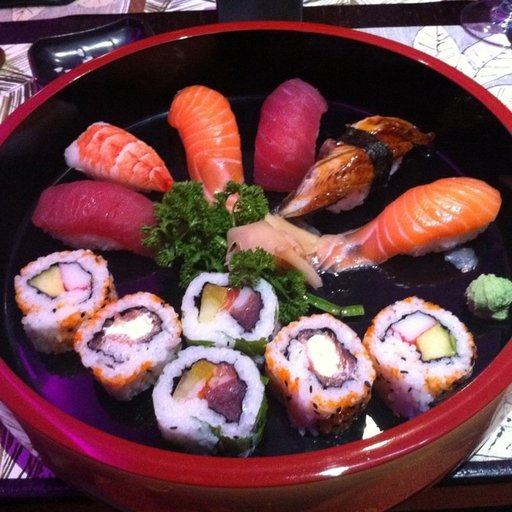

In [9]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
random_image_path

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"height: {img.height} -- width: {img.width}")
img

Image size: (512, 512)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

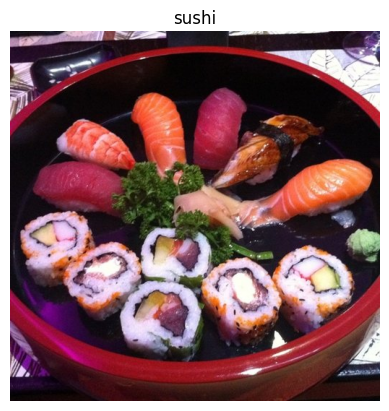

In [10]:
print(f"Image size: {img.size}")
plt.title(image_class)
plt.imshow(img)
plt.axis(False)

In [11]:
img_np = np.asarray(img)

img_np.shape

(512, 512, 3)

## 3. Transforming data

In [12]:
data_transform = transforms.Compose([

    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

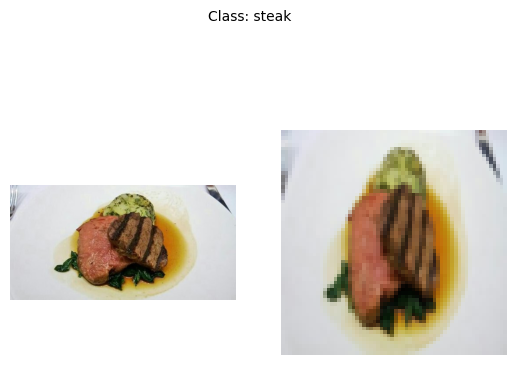

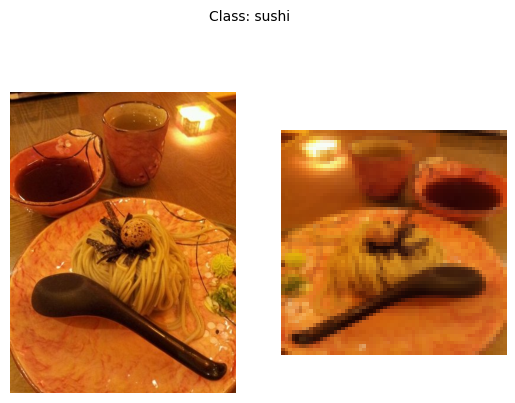

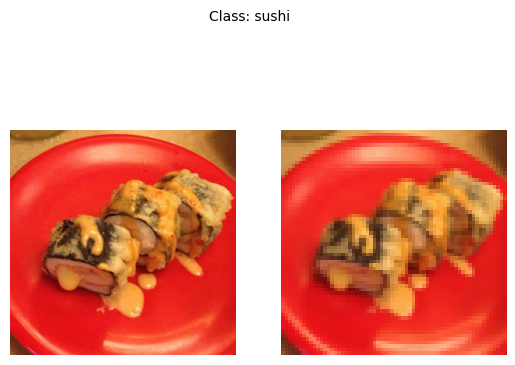

In [13]:
random_image_samples = random.sample(image_path_list, k=3)

for image_path in random_image_samples:

    # with Image.open(image_path, 'r') as f:

    fig, ax = plt.subplots(1, 2)

    img = Image.open(image_path)
    
    image_class = image_path.parent.stem

    ax[0].imshow(img)
    ax[0].axis("off")

    transformed_image = data_transform(img)

    ax[1].imshow(transformed_image.permute(1, 2, 0))
    ax[1].axis("off")

    fig.suptitle(f"Class: {image_class}", fontsize=10)

## 4. Option 1: Loading Image Data Using ImageFolder

In [14]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

In [15]:
len(train_data), len(test_data)

(225, 75)

In [16]:
classes = train_data.classes
classes

['pizza', 'steak', 'sushi']

In [17]:
image, label = train_data[0]
image.shape, label

(torch.Size([3, 64, 64]), 0)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

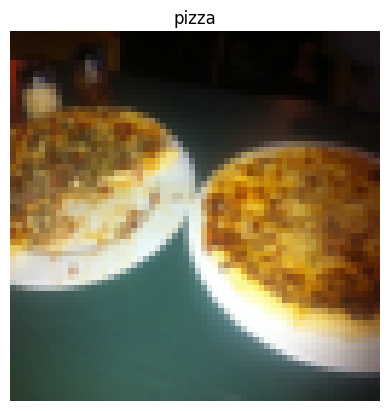

In [18]:
plt.imshow(image.permute(1, 2, 0))
plt.title(label=classes[label])
plt.axis(False)

In [19]:
os.cpu_count()

12

In [20]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=4,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=4,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x20c53368c50>,
 <torch.utils.data.dataloader.DataLoader at 0x20c53324150>)

In [21]:
len(train_dataloader), train_data.classes

(225, ['pizza', 'steak', 'sushi'])

In [22]:
image, label = next(iter(train_dataloader))

In [23]:
image.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

In [25]:
def plot_transformd_images(image_path_list,
                           transform: transforms,
                           n: int,
                           seed):
    

    if seed:

        torch.manual_seed(seed)

    random_image_samples = random.sample(image_path_list, k=n)

    for image_path in random_image_samples:

        # with Image.open(image_path, 'r') as f:

        fig, ax = plt.subplots(1, 2)

        img = Image.open(image_path)
        
        image_class = image_path.parent.stem

        ax[0].imshow(img)
        ax[0].axis("off")

        transformed_image = train_transform(img)

        ax[1].imshow(transformed_image.permute(1, 2, 0))
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_class}", fontsize=10)

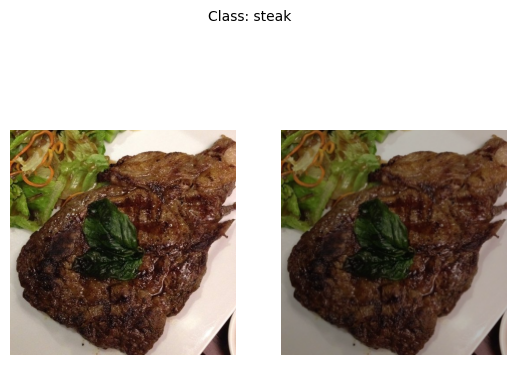

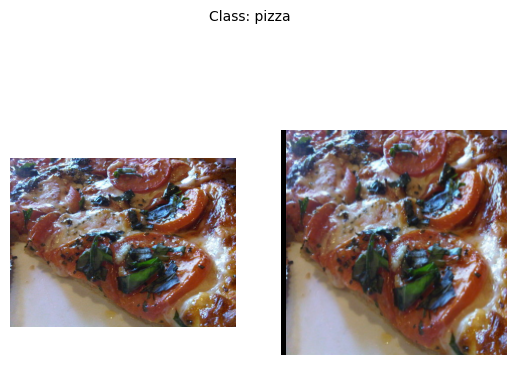

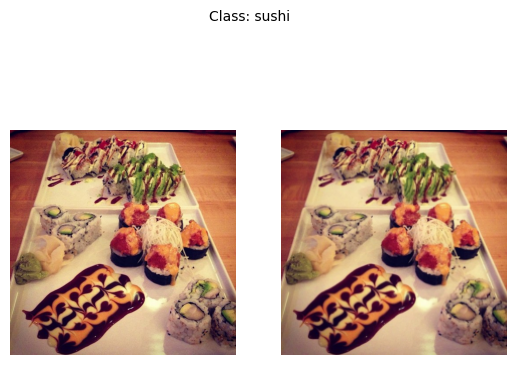

In [26]:
image_path = Path("datasets/pizza_steak_sushi")
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformd_images(image_path_list,
                       train_transform,
                       3,
                       seed=None)

In [27]:
simple_transfrom = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [28]:
train_dir, test_dir

(WindowsPath('datasets/pizza_steak_sushi/train'),
 WindowsPath('datasets/pizza_steak_sushi/test'))

In [29]:
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transfrom
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transfrom
)


## * Turn data into dataloaders

BATCH_SIZE = 32
NUM_WORKERS = 4

train_dataloader = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

len(train_dataloader), len(test_dataloader)

(8, 3)

In [30]:
image, label = next(iter(train_dataloader))

In [31]:
image.shape

torch.Size([32, 3, 64, 64])

In [32]:
64/2/2

16.0

## Print model training time

In [33]:
def print_train_time(start, end, device):

    time = end - start

    day = 0
    hour = 0
    min = 0
    sec = time

    while sec >= 60:

        if hour >= 24:

            day += 1
            hour -= 24

        elif sec >= 3600:

            hour += 1
            sec -= 3600

        elif time >= 60:

            min += 1
            sec -= 60

    day_output = f"{day} day{'s' if day > 1 else ''} : "
    hour_output = f"{hour} hour{'s' if hour > 1 else ''} : "
    min_output = f"{min} min{'s' if min > 1 else ''} : "
    sec_output = f"{sec} sec{'s' if sec > 1 else ''}"

    time_output = f"{day_output if day != 0 else ''}{hour_output if hour != 0 else ''}{min_output if min != 0 else ''}{sec_output if sec != 0 else ''}"

    print(f"Total time taken on {device} is {time_output}")

## Create train and test step

In [34]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               device: torch.device = device):
    
    total_train_loss, total_train_accuray = 0, 0
    model.to(device)

    train_accuracy_fn.reset()

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        model.train()

        logits = model(X)
        train_pred = torch.argmax(logits, dim=1)
        train_loss = loss_fn(logits, y)
        
        total_train_loss += train_loss
        train_accuracy_fn.update(train_pred, y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch % 2 == 0:

            print(f"samples remaning: {batch*BATCH_SIZE} / {len(dataloader)*BATCH_SIZE}")

    total_train_loss /= len(dataloader)
    total_train_accuray = train_accuracy_fn.compute()

    print(f"Train loss: {total_train_loss} --- | Train Accuracy: {total_train_accuray}")

    return total_train_loss, total_train_accuray


def test_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device = device):
    
    total_test_loss, total_test_accuray = 0, 0
    model.to(device)

    model.eval()

    with torch.inference_mode():

        test_accuracy_fn.reset()

        for X, y in dataloader:

            X, y = X.to(device), y.to(device)

            logits = model(X)
            test_pred = torch.argmax(logits, dim=1)
            test_loss = loss_fn(logits, y)
            
            total_test_loss += test_loss
            test_accuracy_fn.update(test_pred, y)

        total_test_loss /= len(dataloader)
        total_test_accuray = test_accuracy_fn.compute()

        print(f"Test loss: {total_test_loss} --- | Test Accuracy: {total_test_accuray}")

    return total_test_loss, total_test_accuray

## fit fn

In [35]:
def fit_fn(model: nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           loss_fn: nn.Module,
           optimizer: torch.optim,
           epochs: int,
           summary_write_path: str,
           device: torch.device = device):
    
    start_time = timer()
    
    writer = SummaryWriter(summary_write_path)

    for epoch in tqdm(range(epochs)):

        train_loss, train_accuracy = train_step(model=model,
                   dataloader=train_dataloader,
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   device=device)

        test_loss, test_accuracy = test_step(model=model,
                   dataloader=test_dataloader,
                   loss_fn=loss_fn,
                   device=device)
        

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)
        
    
    writer.close()

    end_time = timer()

    print_train_time(start=start_time,
                     end=end_time,
                     device=device)

## Get data from Tensorboard

In [36]:
def tensorboard_to_dataframe(value, scalar_events):

    return pd.DataFrame([
        {'epoch': event.step, value: event.value}
        for event in scalar_events
    ])

def get_fit_data(log_dir):

    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # print(f"Available scalars: {ea.Tags()['scalars']}")

    train_loss = ea.Scalars('Loss/train')
    test_loss = ea.Scalars('Loss/test')
    train_accuracy = ea.Scalars('Accuracy/train')
    test_accuracy = ea.Scalars('Accuracy/test')


    train_loss = tensorboard_to_dataframe(value = 'train_loss', scalar_events=train_loss)
    train_accuracy = tensorboard_to_dataframe(value = 'train_accuracy', scalar_events=train_accuracy)
    test_loss = tensorboard_to_dataframe(value = 'test_loss', scalar_events=test_loss)
    test_accuracy = tensorboard_to_dataframe(value = 'test_accuracy', scalar_events=test_accuracy)

    model_results = train_loss.merge(test_loss, how='right')
    model_results = model_results.merge(train_accuracy, how='right')
    model_results = model_results.merge(test_accuracy, how='right')

    return model_results

## Plot Loss and Accuracy curves

In [37]:
def plot_loss_curves(model_results):

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)

    plt.plot(model_results.epoch, model_results.train_loss, label="Train Loss")
    plt.plot(model_results.epoch, model_results.test_loss, label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(model_results.epoch, model_results.train_loss, label="Train Accuracy")
    plt.plot(model_results.epoch, model_results.test_accuracy, label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.legend()

## Create TinyVGG model

In [38]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv_block_1 = nn.Sequential(

            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
            )
        )

        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
            )
        )

        self.classifier = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:

        # x = self.block_1(x)
        # x = self.block_2(x)
        # x = self.classifier(x)

        # return x

        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    
model_0 = TinyVGG(input_shape=3,
                  hidden_units=32,
                  output_shape=3).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=3, bias=True)
  )
)

## Test model on single image forward pass

In [39]:
image_test= image[0]

image_test = image_test.to(device)
label = label.to(device)



logits = model_0(image_test.unsqueeze(dim=0))
pred = logits.argmax(dim=1)
pred, label[0]

(tensor([0], device='cuda:0'), tensor(2, device='cuda:0'))

In [40]:
image[0].shape

torch.Size([3, 64, 64])

In [41]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 32, 64, 64]           896
│    └─ReLU: 2-2                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 32, 64, 64]           9,248
│    └─ReLU: 2-4                         [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 32, 32, 32]           --
├─Sequential: 1-2                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 32, 32, 32]           9,248
│    └─ReLU: 2-7                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 32, 32, 32]           9,248
│    └─ReLU: 2-9                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 32, 16, 16]           --
├─Seq

## Create loss_fn and optimizer

In [42]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## Train model

In [43]:
fit_fn(model=model_0,
       train_dataloader=train_dataloader,
       test_dataloader=test_dataloader,
       loss_fn=loss_fn,
       optimizer=optimizer,
       epochs=5,
       summary_write_path="runs/00-PyTorch-Custom-Datasets/model_0",
       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.095827579498291 --- | Train Accuracy: 0.31111112236976624


 20%|██        | 1/5 [00:15<01:01, 15.36s/it]

Test loss: 1.52957284450531 --- | Test Accuracy: 0.3333333432674408
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.126753807067871 --- | Train Accuracy: 0.3466666638851166


 40%|████      | 2/5 [00:31<00:47, 15.75s/it]

Test loss: 1.0786769390106201 --- | Test Accuracy: 0.41333332657814026
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.1051726341247559 --- | Train Accuracy: 0.3199999928474426


 60%|██████    | 3/5 [00:51<00:35, 17.72s/it]

Test loss: 1.101068377494812 --- | Test Accuracy: 0.25333333015441895
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.101503610610962 --- | Train Accuracy: 0.3333333432674408


 80%|████████  | 4/5 [01:11<00:18, 18.83s/it]

Test loss: 1.1109743118286133 --- | Test Accuracy: 0.3333333432674408
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.1050242185592651 --- | Train Accuracy: 0.3466666638851166


100%|██████████| 5/5 [01:27<00:00, 17.56s/it]

Test loss: 1.0885241031646729 --- | Test Accuracy: 0.41333332657814026
Total time taken on cuda is 1 min : 27.807113599999866 secs


## Plot the curves of model

In [44]:
model_0_results = get_fit_data("runs/00-PyTorch-Custom-Datasets/model_0")

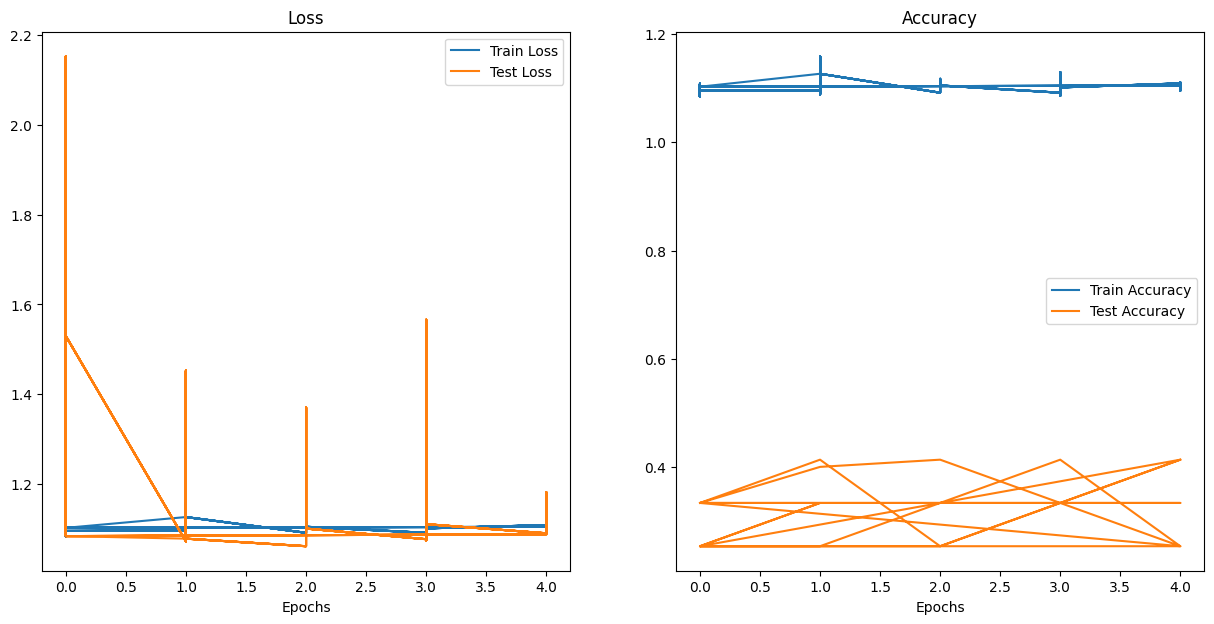

In [45]:
plot_loss_curves(model_0_results)

## Model 1: TinyVGG with Data Augmentation

### Create transform with data augmentation

In [46]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [47]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial_augment)

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                           transform=test_transform_trivial_augment)

In [ ]:
train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_augmented = DataLoader(
    dataset=test_data_augmented,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x20c546883d0>,
 <torch.utils.data.dataloader.DataLoader at 0x20c5488c150>)

In [69]:
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=64,
    output_shape=len(classes)
)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=3, bias=True)
  )
)

In [71]:
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

## Train model

In [70]:
model_1_log_dir = "runs/00-PyTorch-Custom-Datasets/model_1"

fit_fn(model=model_1,
       train_dataloader=train_dataloader_augmented,
       test_dataloader=test_dataloader_augmented,
       loss_fn=loss_fn,
       optimizer=optimizer,
       epochs=5,
       summary_write_path=model_1_log_dir,
       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.1007148027420044 --- | Train Accuracy: 0.35111111402511597


 20%|██        | 1/5 [00:12<00:48, 12.09s/it]

Test loss: 1.0968244075775146 --- | Test Accuracy: 0.3333333432674408
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.0994668006896973 --- | Train Accuracy: 0.3466666638851166


 40%|████      | 2/5 [00:26<00:40, 13.62s/it]

Test loss: 1.0968244075775146 --- | Test Accuracy: 0.3333333432674408
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.0991424322128296 --- | Train Accuracy: 0.3466666638851166


 60%|██████    | 3/5 [00:43<00:29, 14.82s/it]

Test loss: 1.0968244075775146 --- | Test Accuracy: 0.3333333432674408
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.0962194204330444 --- | Train Accuracy: 0.3466666638851166


 80%|████████  | 4/5 [00:59<00:15, 15.38s/it]

Test loss: 1.0968244075775146 --- | Test Accuracy: 0.3333333432674408
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 1.0951495170593262 --- | Train Accuracy: 0.3466666638851166


100%|██████████| 5/5 [01:15<00:00, 15.03s/it]

Test loss: 1.0968244075775146 --- | Test Accuracy: 0.3333333432674408
Total time taken on cuda is 1 min : 15.173445000000356 secs


## Get the loss and accuracy data

In [51]:
model_1_results = get_fit_data(model_1_log_dir)

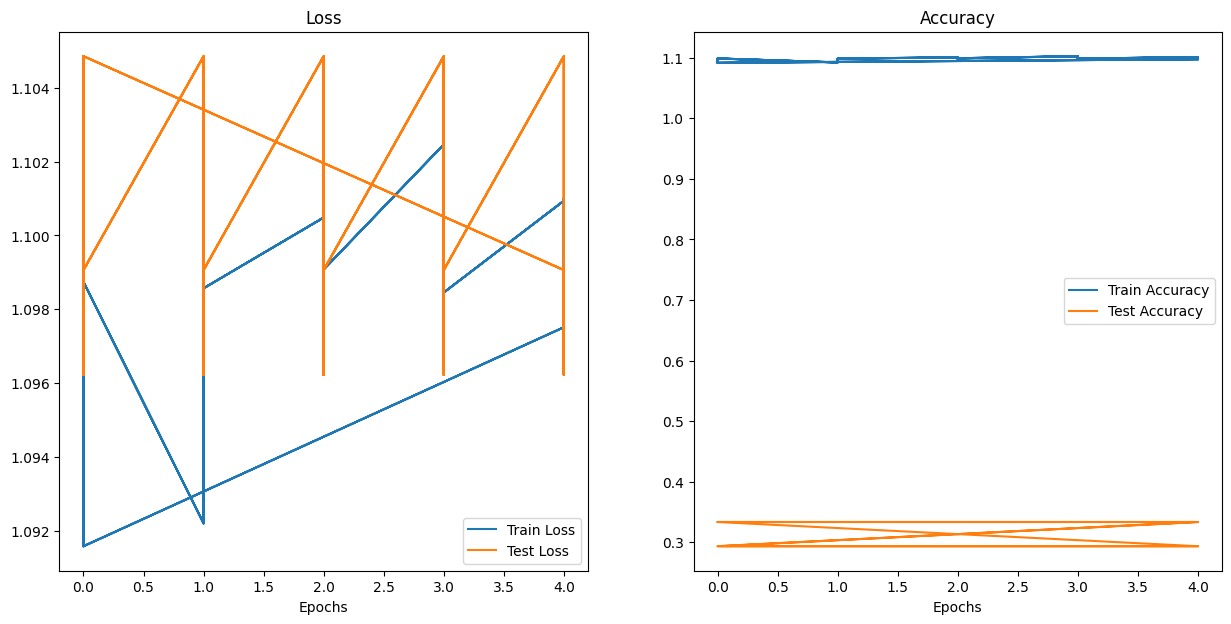

In [52]:
plot_loss_curves(model_1_results)

## let's make prediction on custom image

In [53]:
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")

In [54]:
custom_image_path = data_path / "pizza-dad.jpeg"

with open(custom_image_path, "wb") as f:

    f.write(request.content)

In [55]:
custom_image = torchvision.io.read_image(custom_image_path)

In [56]:
custom_image.shape, custom_image.dtype

(torch.Size([3, 4032, 3024]), torch.uint8)

In [57]:
# ! Error because of data type

# model_1.eval()

# with torch.inference_mode():

#     logits = model_1(custom_image)
# logits

In [58]:
custom_image = custom_image / 255

In [59]:
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

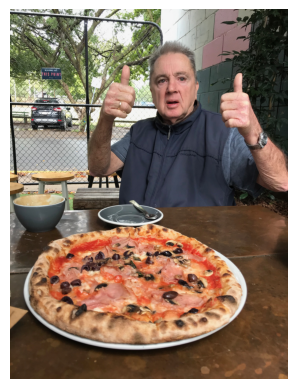

In [60]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.axis(False)

In [61]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

In [62]:
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

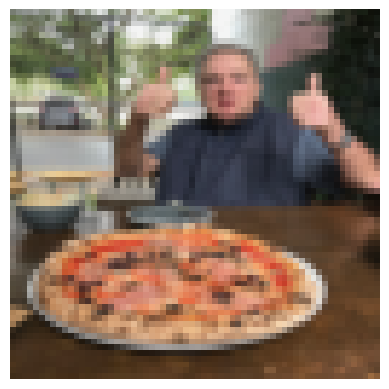

In [63]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.axis(False)

In [64]:
device

'cuda'

In [65]:
custom_image_transformed = custom_image_transformed.unsqueeze(dim=0).to(device)

In [66]:
model_1.eval

with torch.inference_mode():

    logits = model_1(custom_image_transformed)
    preds = logits.argmax(dim=1)
preds, classes[preds.item()]

(tensor([2], device='cuda:0'), 'sushi')

In [67]:
pred_prob = torch.softmax(logits, dim=1)
pred = pred_prob.argmax(dim=1)
pred, pred_prob

(tensor([2], device='cuda:0'),
 tensor([[0.3331, 0.3320, 0.3349]], device='cuda:0'))

In [68]:
logits, logits.argmax(dim=1)

(tensor([[-0.0023, -0.0055,  0.0031]], device='cuda:0'),
 tensor([2], device='cuda:0'))